In [61]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import plot_2d_y, plot_2d

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model_and_train(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], 
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture, 
        "tanh", 
        "Glorot normal")

    model = dde.Model(data, net)

    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return data, model, losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)
    plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(), 
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!! 
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plot_2d(X_train_next_batch, "train_next_batch")

def predict_and_output_report(X_test, y_true, model, losshistory = None, train_state = None):
    # Analytical test solution
    plot_2d_y(X_test, y_true, "Analytical solution")

    # Physics Informed Neural Network test solution``
    y_pred = model.predict(X_test)
    plot_2d_y(X_test, y_pred, "PINN prediction")

    # Train loss, and Test data from PDE test data
    # DONT LOOK AT THIS PDE test data SOLUTION PLOT!!!
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)

    f = model.predict(X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_true, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()
  
X_test, y_true = gen_data(
    "heat_1d_boundary_sin_exact",
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim, 
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    })


# Test 1: Default parameters from DeepXde

In [51]:
geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, PinnTestParam())

Compiling model...
Building feed-forward neural network...
'build' took 0.028006 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
2021-12-08 12:43:06.277268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 12:43:06.277738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER c

'compile' took 0.399021 s

Initializing variables...
Training model...

0         [8.07e-02, 2.69e-02, 5.03e-01]    [7.90e-02, 2.69e-02, 5.03e-01]    []  
1000      [7.94e-04, 4.79e-04, 8.69e-05]    [4.47e-04, 4.79e-04, 8.69e-05]    []  
2000      [2.06e-04, 3.51e-05, 6.42e-06]    [1.46e-04, 3.51e-05, 6.42e-06]    []  
3000      [1.17e-04, 4.75e-06, 4.74e-06]    [9.40e-05, 4.75e-06, 4.74e-06]    []  
4000      [8.23e-05, 1.78e-06, 2.46e-06]    [6.27e-05, 1.78e-06, 2.46e-06]    []  
5000      [5.95e-05, 1.35e-06, 1.86e-06]    [4.59e-05, 1.35e-06, 1.86e-06]    []  
6000      [4.50e-05, 1.65e-06, 3.28e-06]    [3.39e-05, 1.65e-06, 3.28e-06]    []  
7000      [3.59e-05, 1.15e-06, 2.91e-06]    [2.86e-05, 1.15e-06, 2.91e-06]    []  
8000      [2.74e-05, 9.39e-07, 9.56e-07]    [2.00e-05, 9.39e-07, 9.56e-07]    []  
9000      [7.19e-05, 3.24e-05, 1.13e-04]    [7.12e-05, 3.24e-05, 1.13e-04]    []  
10000     [1.54e-04, 4.49e-05, 1.67e-05]    [1.05e-04, 4.49e-05, 1.67e-05]    []  
11000     [1.64

train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


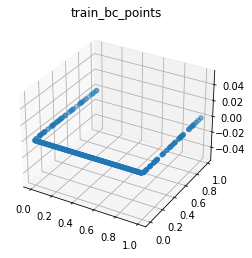

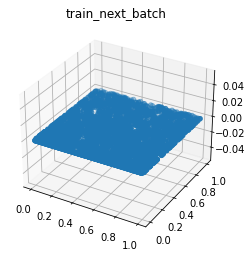

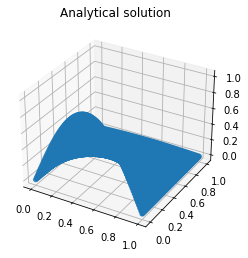

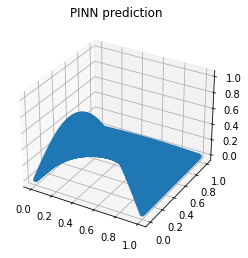

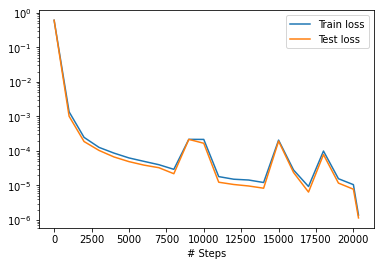

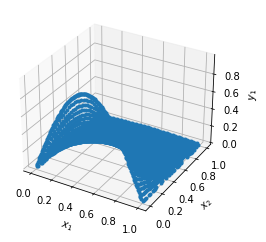

Mean residual: 0.0008361383
L2 relative error: 0.0004414280597969284


In [52]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

In [53]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.015408 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_

'compile' took 0.364024 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.10e-03, 1.09e-01, 2.15e-01]    [2.15e-03, 1.09e-01, 2.15e-01]    []  
1000      [1.13e-02, 3.73e-02, 6.11e-02]    [8.87e-03, 3.73e-02, 6.11e-02]    []  
2000      [1.34e-02, 1.92e-02, 3.24e-02]    [1.02e-02, 1.92e-02, 3.24e-02]    []  
3000      [1.36e-02, 1.40e-02, 2.53e-02]    [1.08e-02, 1.40e-02, 2.53e-02]    []  
4000      [1.41e-02, 1.23e-02, 2.23e-02]    [1.12e-02, 1.23e-02, 2.23e-02]    []  
5000      [1.42e-02, 1.08e-02, 1.96e-02]    [1.12e-02, 1.08e-02, 1.96e-02]    []  
6000      [1.42e-02, 1.01e-02, 1.75e-02]    [1.11e-02, 1.01e-02, 1.75e-02]    []  
7000      [1.40e-02, 9.60e-03, 1.66e-02]    [1.10e-02, 9.60e-03, 1.66e-02]    []  
8000      [1.39e-02, 9.06e-03, 1.59e-02]    [1.10e-02, 9.06e-03, 1.59e-02]    []  
9000      [1.39e-02, 8.34e-03, 1.53e-02]    [1.10e-02, 8.34e-03, 1.53e-02]    []  
10000   

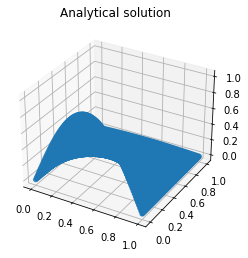

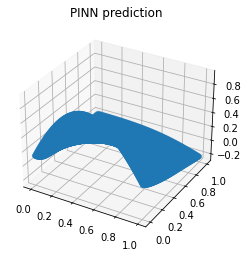

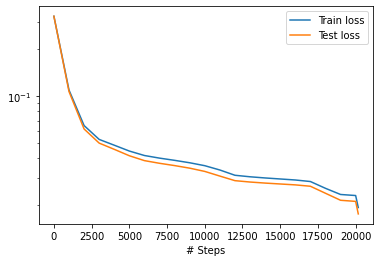

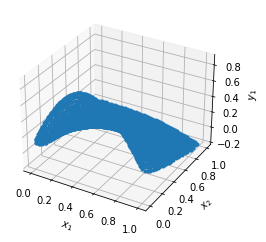

Mean residual: 0.06890949
L2 relative error: 0.19788800052300648


In [54]:
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 3: Reduce boundary points to break solution

In [55]:
test_params = PinnTestParam()
test_params.d_num_boundary = 2
test_params.d_num_initial = 2

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.028369 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-08 12:44:11.002093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful N

'compile' took 0.755050 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.16e-02, 3.06e-02, 3.38e-01]    [3.14e-02, 3.06e-02, 3.38e-01]    []  
1000      [1.46e-04, 4.74e-06, 8.88e-07]    [1.31e-04, 4.74e-06, 8.88e-07]    []  
2000      [3.21e-05, 2.87e-07, 6.42e-07]    [2.84e-05, 2.87e-07, 6.42e-07]    []  
3000      [1.70e-05, 2.08e-08, 2.09e-08]    [1.45e-05, 2.08e-08, 2.09e-08]    []  
4000      [2.13e-05, 8.00e-05, 5.66e-05]    [1.77e-05, 8.00e-05, 5.66e-05]    []  
5000      [1.04e-05, 2.41e-06, 1.46e-06]    [9.00e-06, 2.41e-06, 1.46e-06]    []  
6000      [8.22e-06, 2.73e-09, 7.68e-09]    [7.01e-06, 2.73e-09, 7.68e-09]    []  
7000      [6.45e-06, 2.05e-09, 4.72e-09]    [5.50e-06, 2.05e-09, 4.72e-09]    []  
8000      [5.13e-06, 9.00e-06, 6.97e-06]    [4.37e-06, 9.00e-06, 6.97e-06]    []  
9000      [4.14e-06, 6.50e-06, 4.84e-06]    [3.41e-06, 6.50e-06, 4.84e-06]    []  
10000   

train_bc_points shape (4, 2)
train_next_batch shape (2548, 2)


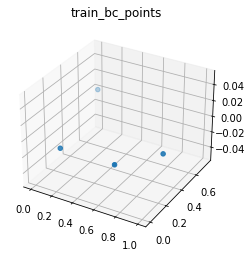

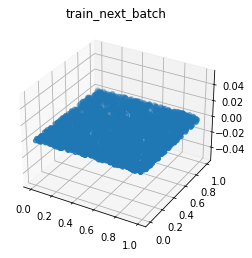

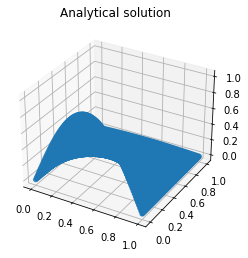

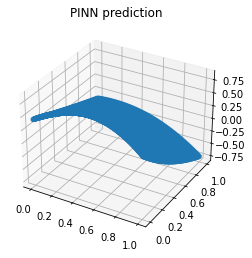

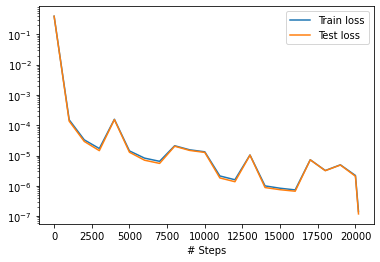

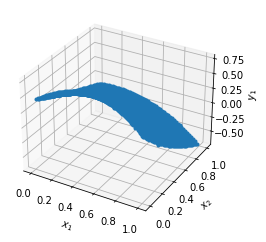

Mean residual: 0.0002915533
L2 relative error: 0.7712139794324735


In [56]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

In [57]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.028116 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_l

'compile' took 0.429690 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.50e-01, 1.22e-01, 2.50e-01]    [4.92e-01, 1.22e-01, 2.50e-01]    []  
1000      [3.37e-03, 2.92e-03, 3.48e-03]    [8.04e-03, 2.92e-03, 3.48e-03]    []  
2000      [7.25e-04, 2.57e-04, 2.76e-04]    [1.33e-03, 2.57e-04, 2.76e-04]    []  
3000      [2.61e-04, 1.77e-04, 1.33e-04]    [4.40e-04, 1.77e-04, 1.33e-04]    []  
4000      [1.33e-04, 1.11e-04, 7.88e-05]    [3.06e-04, 1.11e-04, 7.88e-05]    []  
5000      [2.34e-04, 9.33e-05, 5.74e-05]    [3.11e-04, 9.33e-05, 5.74e-05]    []  
6000      [6.42e-05, 6.71e-05, 5.12e-05]    [2.36e-04, 6.71e-05, 5.12e-05]    []  
7000      [4.81e-05, 2.85e-05, 1.78e-05]    [1.88e-04, 2.85e-05, 1.78e-05]    []  
8000      [4.18e-05, 2.11e-05, 1.20e-05]    [1.67e-04, 2.11e-05, 1.20e-05]    []  
9000      [3.73e-05, 1.63e-05, 8.83e-06]    [1.53e-04, 1.63e-05, 8.83e-06]    []  
10000   

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


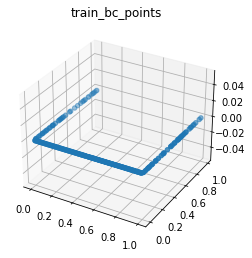

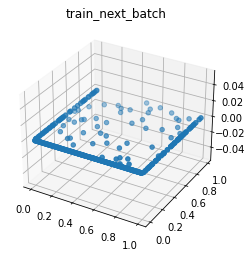

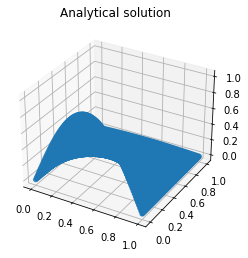

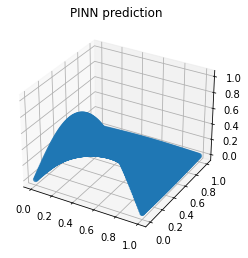

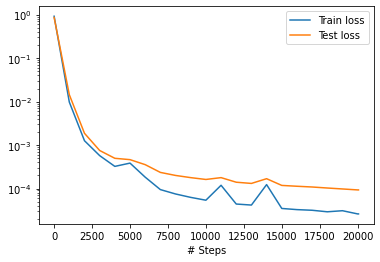

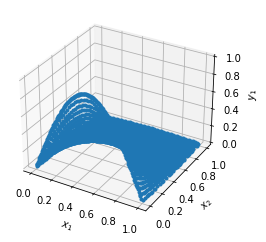

Mean residual: 0.007113696
L2 relative error: 0.005670521350935891


In [58]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 5: Reduce train data (domain and bc) to break solution

In [59]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model, losshistory, train_state = create_model_and_train(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.030629 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base

'compile' took 0.809846 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.80e-01, 6.81e-02, 3.96e-01]    [2.70e-01, 6.81e-02, 3.96e-01]    []  
1000      [1.14e-03, 1.51e-03, 1.76e-03]    [1.42e-03, 1.51e-03, 1.76e-03]    []  
2000      [3.13e-04, 3.06e-04, 4.65e-05]    [7.93e-04, 3.06e-04, 4.65e-05]    []  
3000      [8.88e-05, 1.07e-04, 6.63e-06]    [6.47e-04, 1.07e-04, 6.63e-06]    []  
4000      [5.22e-05, 3.91e-05, 2.68e-06]    [4.00e-04, 3.91e-05, 2.68e-06]    []  
5000      [2.94e-05, 1.06e-05, 6.42e-06]    [2.09e-04, 1.06e-05, 6.42e-06]    []  
6000      [1.75e-05, 4.12e-06, 7.54e-07]    [1.34e-04, 4.12e-06, 7.54e-07]    []  
7000      [1.49e-05, 3.37e-06, 2.64e-06]    [1.04e-04, 3.37e-06, 2.64e-06]    []  
8000      [1.08e-05, 1.79e-06, 3.33e-07]    [8.33e-05, 1.79e-06, 3.33e-07]    []  
9000      [1.30e-05, 3.11e-06, 5.05e-06]    [7.39e-05, 3.11e-06, 5.05e-06]    []  
10000   

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


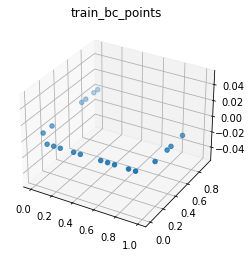

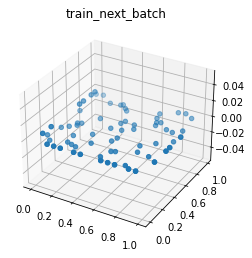

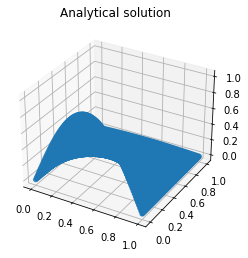

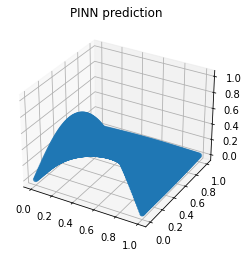

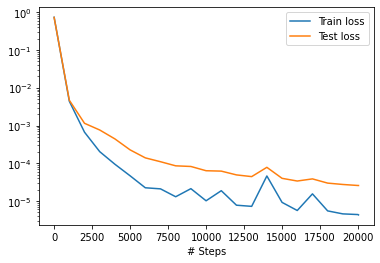

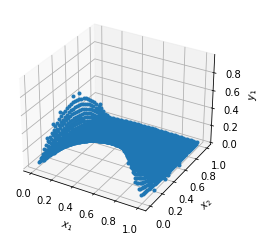

Mean residual: 0.0031376851
L2 relative error: 0.006621632730106989


In [60]:
plot_train_data(geomtime_data)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)